Alright! I'm gonna try to get some info about my Spotify playlists.

If you don't want to see all the beautiful plots I made you can go down straight to the Conclusions section.

[Conclusions](#Conclusions)

In [1]:
%matplotlib inline

import os
import my_spotify_credentials as credentials
import numpy as np
import pandas as pd
import ujson
import spotipy
import spotipy.util
import seaborn as sns
from bokeh.charts import Histogram, Scatter, Donut, show
from bokeh.io import output_notebook
from bokeh.models import HoverTool, ColumnDataSource
from bokeh import palettes

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
The bokeh.charts API has moved to a separate 'bkcharts' package.

This compatibility shim will remain until Bokeh 1.0 is released.
After that, if you want to use this API you will have to install
the bkcharts package explicitly.

  warn(message)


Please note that I had to configure my Spotify Dev account credentials (https://spotipy.readthedocs.io/en/latest/#authorization-code-flow) in order to fetch some of the following requests.

Setting up the scope (https://developer.spotify.com/web-api/using-scopes/), the username and then request the songs in my library filtering some fields (I'm only gonna work with the following info: song names, artists, song duration, the date I added that song to my library and its popularity).

In [2]:
os.environ["SPOTIPY_CLIENT_ID"] = credentials.SPOTIPY_CLIENT_ID
os.environ["SPOTIPY_CLIENT_SECRET"] = credentials.SPOTIPY_CLIENT_SECRET
os.environ["SPOTIPY_REDIRECT_URI"] = credentials.SPOTIPY_REDIRECT_URI

scope = 'user-library-read'
username = 'jose.vicente'

token = spotipy.util.prompt_for_user_token(username, scope)

if token:
    spotipy_obj = spotipy.Spotify(auth=token)
    saved_tracks_resp = spotipy_obj.current_user_saved_tracks(limit=50)
else:
    print('Couldn\'t get token for that username')
    
number_of_tracks = saved_tracks_resp['total']
print('%d tracks' % number_of_tracks)

def save_only_some_fields(track_response):
    return {        
        'id': str(track_response['track']['id']),
        'name': str(track_response['track']['name']),
        'artists': [artist['name'] for artist in track_response['track']['artists']],
        'duration_ms': track_response['track']['duration_ms'],
        'popularity': track_response['track']['popularity'],
        'added_at': track_response['added_at']
    }

tracks = [save_only_some_fields(track) for track in saved_tracks_resp['items']]

while saved_tracks_resp['next']:
    saved_tracks_resp = spotipy_obj.next(saved_tracks_resp)
    tracks.extend([save_only_some_fields(track) for track in saved_tracks_resp['items']])

487 tracks


Let's modify the data collected to work more easily with it.

In [3]:
tracks_df = pd.DataFrame(tracks)
pd.set_option('display.max_rows', len(tracks))

In case there are more than one artists, I only care for the first one. I'm gonna transform the length to seconds.

In [4]:
#pd.reset_option('display.max_rows')

tracks_df['artists'] = tracks_df['artists'].apply(lambda artists: artists[0])
tracks_df['duration_ms'] = tracks_df['duration_ms'].apply(lambda duration: duration/1000)

tracks_df = tracks_df.rename(columns = {'duration_ms':'duration_s'})

Let's make some plots, but first, let's explain (copy - paste) some concepts.

* Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

* Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

* The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.

* Valence is a measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

* Tempo: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

In [5]:
audio_features = {}

for idd in tracks_df['id'].tolist():
    audio_features[idd] = spotipy_obj.audio_features(idd)[0]
    
tracks_df['acousticness'] = tracks_df['id'].apply(lambda idd: audio_features[idd]['acousticness'])
tracks_df['speechiness'] = tracks_df['id'].apply(lambda idd: audio_features[idd]['speechiness'])
tracks_df['key'] = tracks_df['id'].apply(lambda idd: str(audio_features[idd]['key']))
tracks_df['liveness'] = tracks_df['id'].apply(lambda idd: audio_features[idd]['liveness'])
tracks_df['instrumentalness'] = tracks_df['id'].apply(lambda idd: audio_features[idd]['instrumentalness'])
tracks_df['energy'] = tracks_df['id'].apply(lambda idd: audio_features[idd]['energy'])
tracks_df['tempo'] = tracks_df['id'].apply(lambda idd: audio_features[idd]['tempo'])
tracks_df['time_signature'] = tracks_df['id'].apply(lambda idd: audio_features[idd]['time_signature'])
tracks_df['loudness'] = tracks_df['id'].apply(lambda idd: audio_features[idd]['loudness'])
tracks_df['danceability'] = tracks_df['id'].apply(lambda idd: audio_features[idd]['danceability'])
tracks_df['valence'] = tracks_df['id'].apply(lambda idd: audio_features[idd]['valence'])

In [6]:
output_notebook()

show(Histogram(tracks_df['popularity'], title='Tracks popularity', bins=25, density=False, plot_width=800))

show(Histogram(tracks_df[tracks_df['duration_s'] < 700]['duration_s'], 
               title='Tracks length (Tubular Bells removed)', density=False, plot_width=800))

show(Scatter(tracks_df, x='valence', y='danceability', 
             title='danceability vs valence', color='navy', plot_width=800))

show(Scatter(tracks_df, x='energy', y='loudness', 
             title='loudness vs energy', color='navy', plot_width=800))

show(Scatter(tracks_df, x='energy', y='valence', 
             title='valence vs energy', color='navy', plot_width=800))

# sns.plt.figure(figsize=(15, 10))
# sns.pairplot(tracks_df)
# sns.plt.show()

Loading BokehJS ...

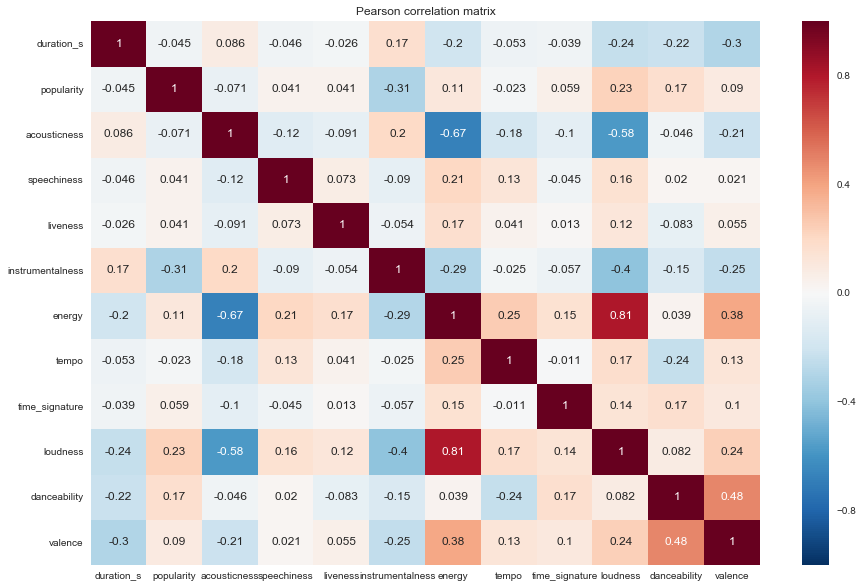

In [7]:
sns.plt.figure(figsize=(15, 10))
corr = tracks_df.corr()
sns.heatmap(corr, annot=True).set_title('Pearson correlation matrix')
sns.plt.show()

In [8]:
artitsts_songs_df = tracks_df['artists'].value_counts()[:15]

p = Donut(artitsts_songs_df, plot_width=850, plot_height=800, 
           color=palettes.RdBu9, title='Number of tracks by artist')
show(p)

Number of tracks by artist

In [9]:
tracks_df['artists'].value_counts()

Oasis                                                32
The Vaccines                                         19
Coldplay                                             15
Metallica                                            15
Love of Lesbian                                      13
Nirvana                                              12
Los Punsetes                                          9
David Bowie                                           8
Foo Fighters                                          7
Ramin Djawadi                                         7
Green Day                                             7
Sia                                                   7
Ramones                                               6
Linkin Park                                           6
Kygo                                                  6
Two Door Cinema Club                                  6
Queen                                                 6
The Animals                                     

Some stats about my songs

In [10]:
first_describe = tracks_df.describe()
first_describe.loc[['mean','std','50%','min','max'],:]

,duration_s,popularity,acousticness,speechiness,liveness,instrumentalness,energy,tempo,time_signature,loudness,danceability,valence
mean,251.881850,52.392197,0.155311,0.060528,0.207912,0.113398,0.718745,125.520392,3.950719,-7.155335,0.509394,0.493161
std,100.764767,22.435829,0.245062,0.051651,0.175849,0.255677,0.211414,28.230377,0.267657,3.719604,0.154199,0.249439
50%,236.440000,56.000000,0.030600,0.042100,0.134000,0.000633,0.769000,122.093000,4.000000,-6.260000,0.512000,0.498000
min,68.720000,0.000000,0.000001,0.024300,0.025900,0.000000,0.011200,68.560000,1.000000,-27.908000,0.069500,0.033100
max,1561.133000,100.000000,0.993000,0.375000,0.980000,0.967000,0.988000,204.397000,5.000000,-1.634000,0.969000,0.965000


In [11]:
print('''
The median value of my songs popularity is %.2f and the median value of my songs length is %f minutes.

The longest track lasts %f minutes and the shortest one lasts %f minutes.
''' % (first_describe['popularity']['50%'], first_describe['duration_s']['50%']/60, 
       first_describe['duration_s']['max']/60, first_describe['duration_s']['min']/60))


The median value of my songs popularity is 56.00 and the median value of my songs length is 3.940667 minutes.

The longest track lasts 26.018883 minutes and the shortest one lasts 1.145333 minutes.



The following cells show the longest song and the shortest song:

In [12]:
tracks_df.iloc[ tracks_df['duration_s'].idxmax() ][['artists','name']]

artists            Mike Oldfield
name       Tubular Bells - Pt. I
Name: 141, dtype: object

In [13]:
tracks_df.iloc[ tracks_df['duration_s'].idxmin() ][['artists','name']]

artists    The Hives
name        Come On!
Name: 345, dtype: object

Popularity ranking (songs' popularity vary over the time so this ranking may be different everytime this notebook is executed).

In [14]:
tracks_df[['added_at','name', 'artists', 'popularity']].sort_values('popularity', ascending=False)

,added_at,name,artists,popularity
4,2017-09-23T12:42:55Z,Unforgettable,French Montana,100
66,2017-06-23T09:25:40Z,Swalla (feat. Nicki Minaj & Ty Dolla $ign),Jason Derulo,95
18,2017-08-22T18:26:47Z,Feels,Calvin Harris,91
10,2017-08-30T14:35:16Z,Believer,Imagine Dragons,90
122,2017-03-05T18:59:24Z,It Ain't Me (with Selena Gomez),Kygo,89
1,2017-09-24T12:05:53Z,Slide,Calvin Harris,88
107,2017-03-11T19:48:56Z,Something Just Like This,The Chainsmokers,88
257,2016-11-17T11:33:38Z,In the Name of Love,Martin Garrix,87
338,2016-06-19T12:39:33Z,Don't Let Me Down,The Chainsmokers,87
38,2017-07-22T14:12:35Z,In The End,Linkin Park,86


Some boxplots to have a better knowledge of my songs popularity and duration

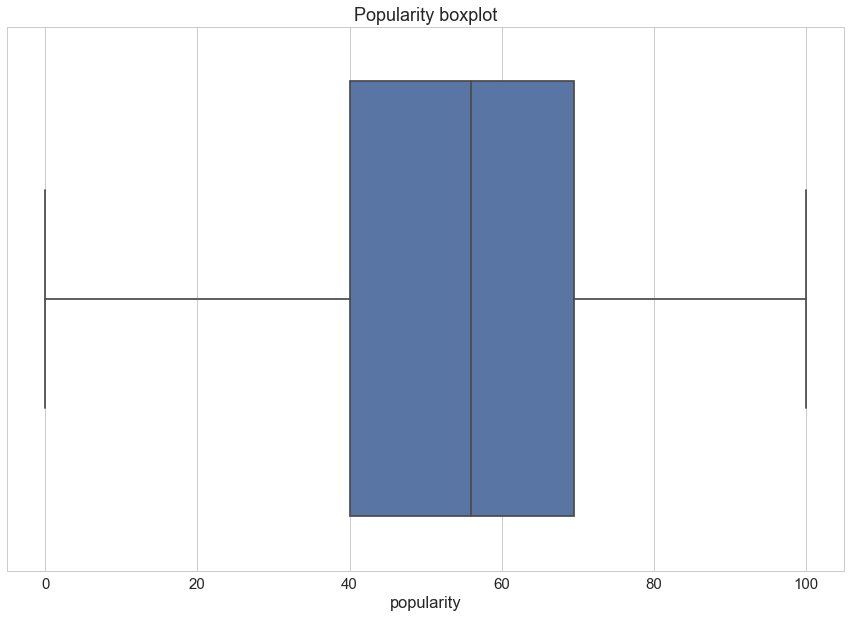

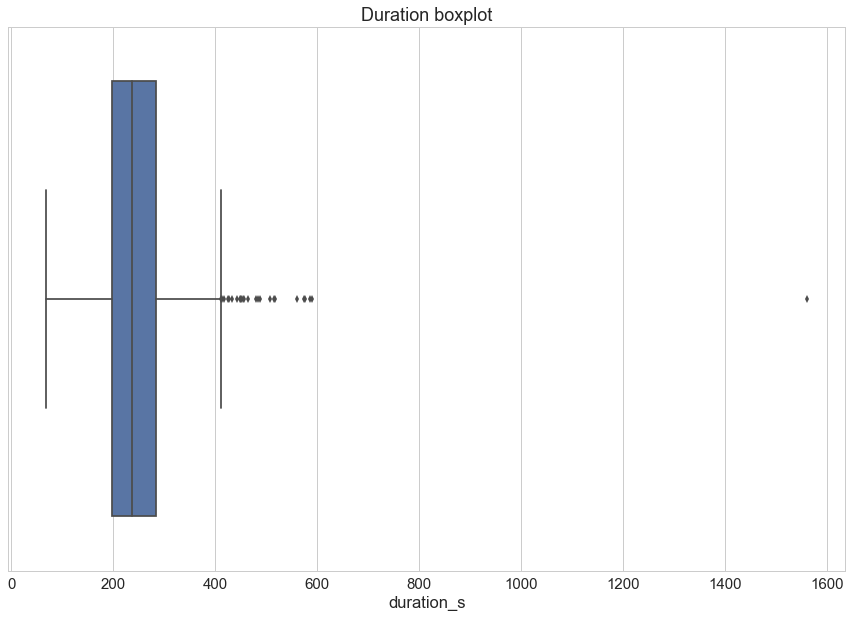

In [15]:
sns.set_context('notebook', font_scale=1.5)
sns.set_style('whitegrid')

sns.plt.figure(figsize=(15, 10))
sns.boxplot(x=tracks_df['popularity']).set_title('Popularity boxplot')
sns.plt.show()

sns.plt.figure(figsize=(15, 10))
sns.boxplot(x=tracks_df['duration_s']).set_title('Duration boxplot')
sns.plt.show()

In [16]:
def plot_time_series(col_name, title, rolling_window_days):
    daily_series = pd.Series(data=np.array(tracks_df[col_name]), 
                                      name=col_name, 
                                      index=tracks_df['added_at']).sort_index()

    (daily_series.rolling(window = rolling_window_days)
     .mean()
     .plot(figsize=(30, 10))
     .set(xlabel='date (by day)', ylabel=col_name, title=title))

    sns.plt.show()    

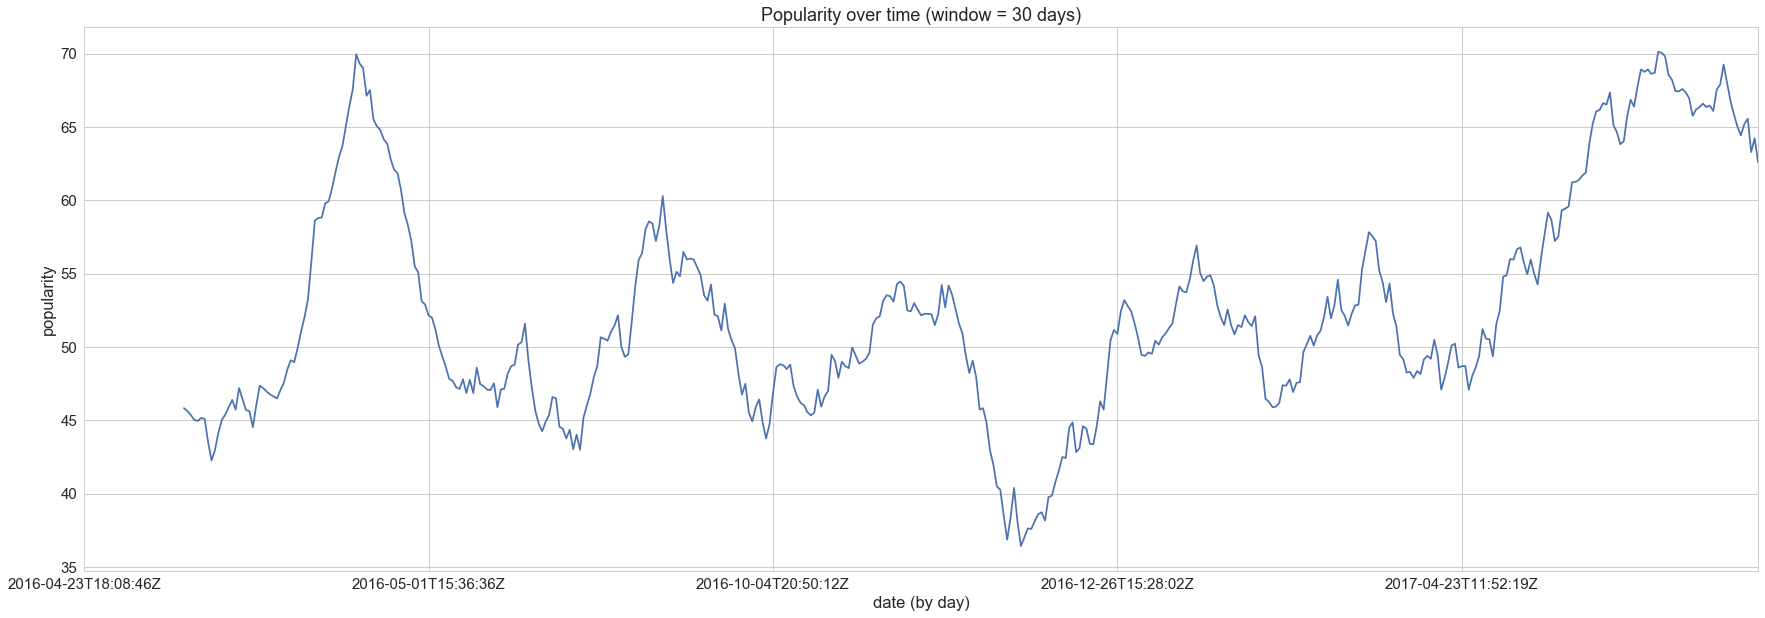

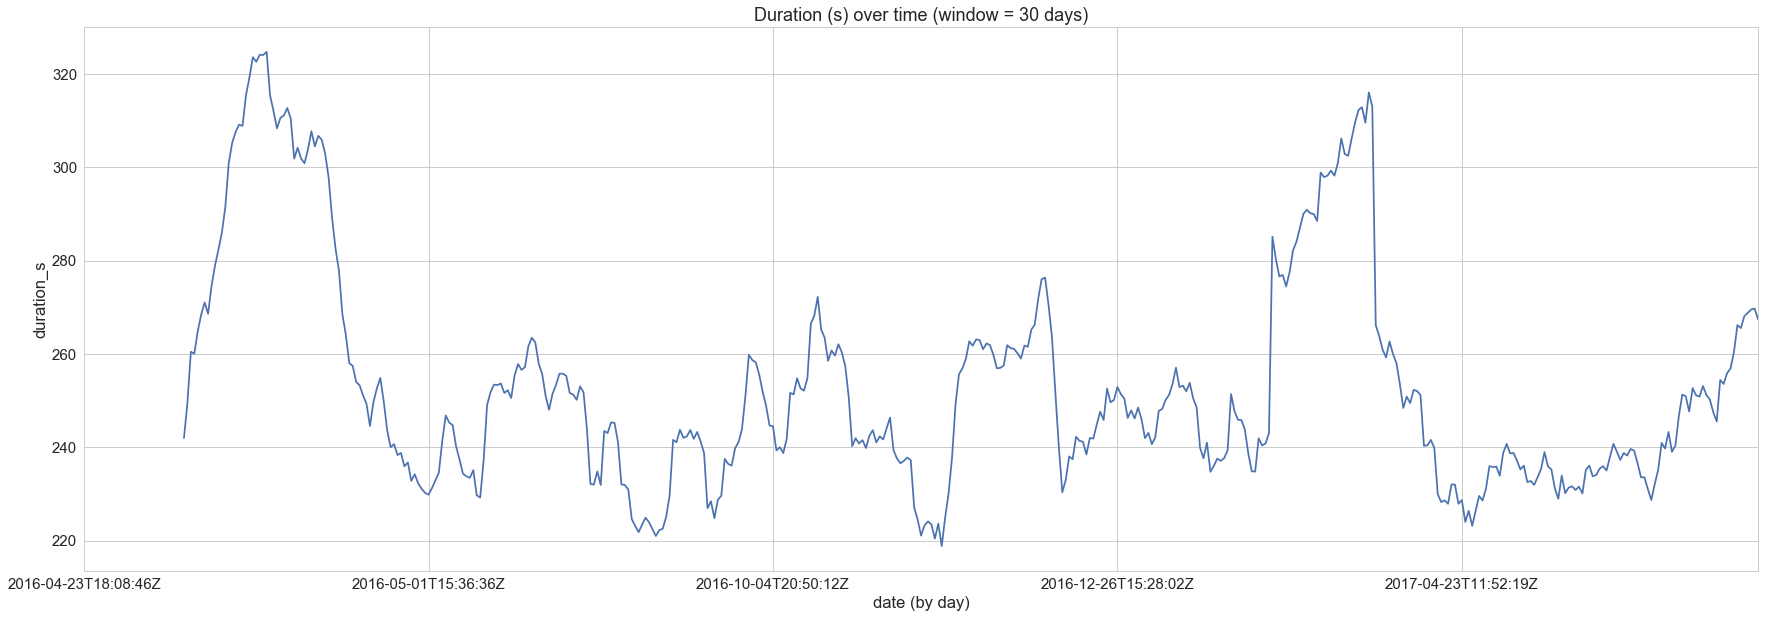

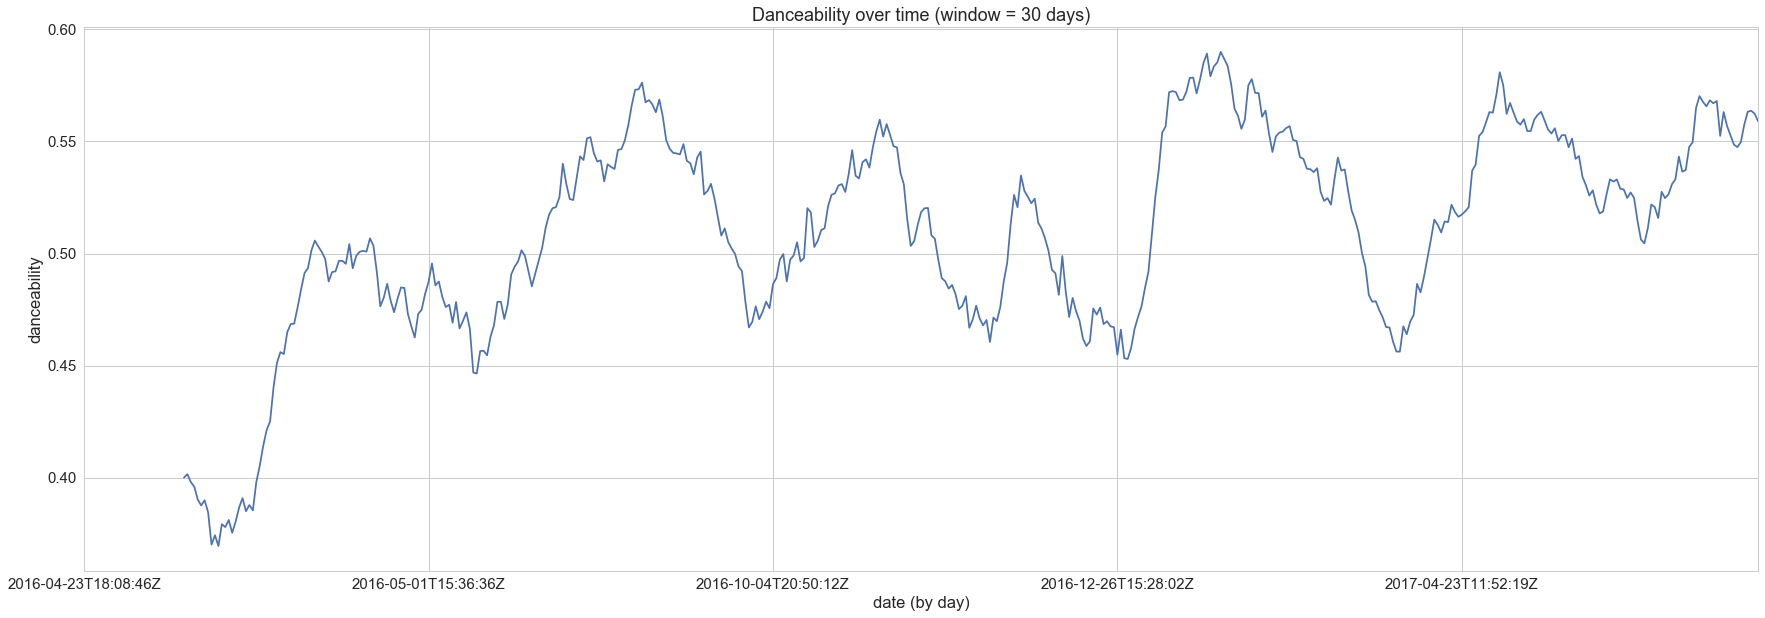

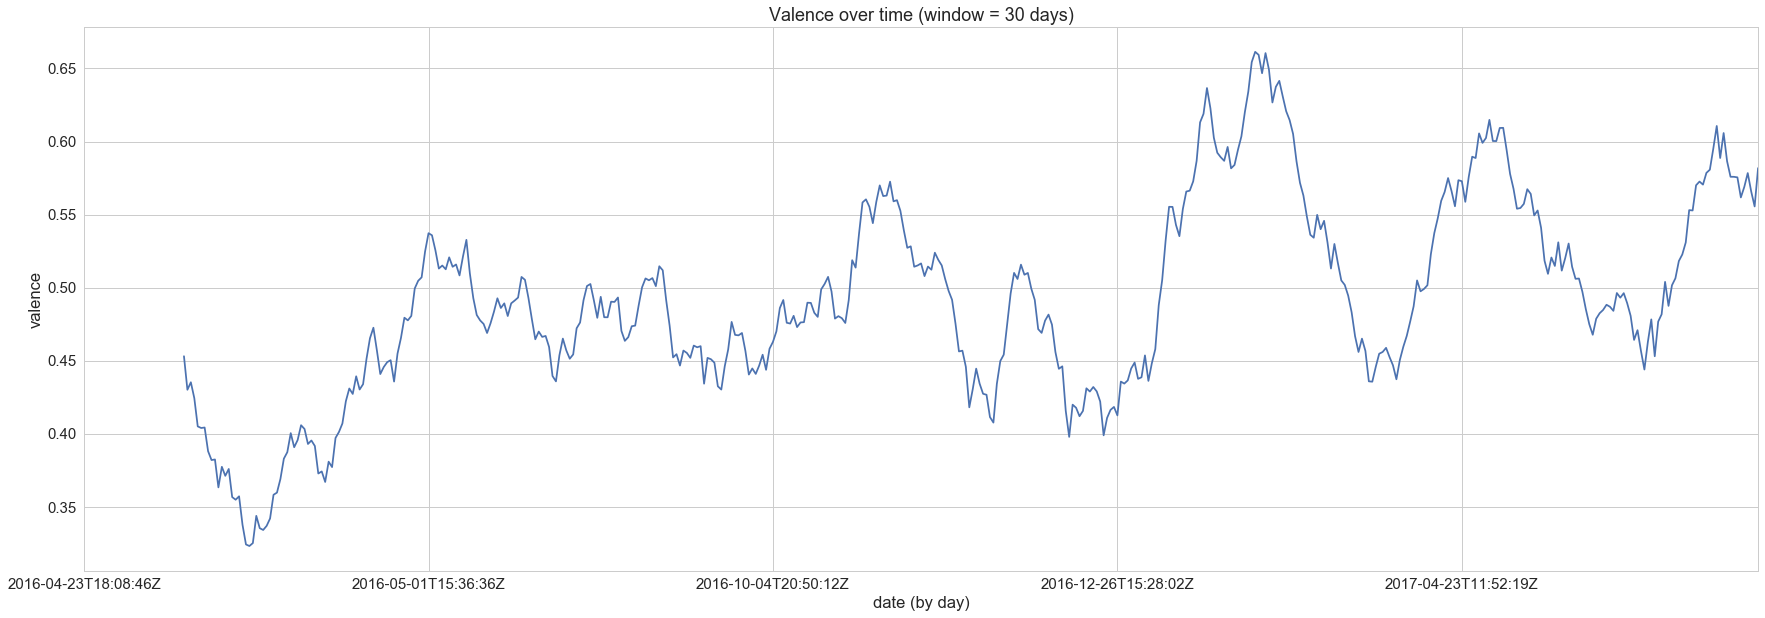

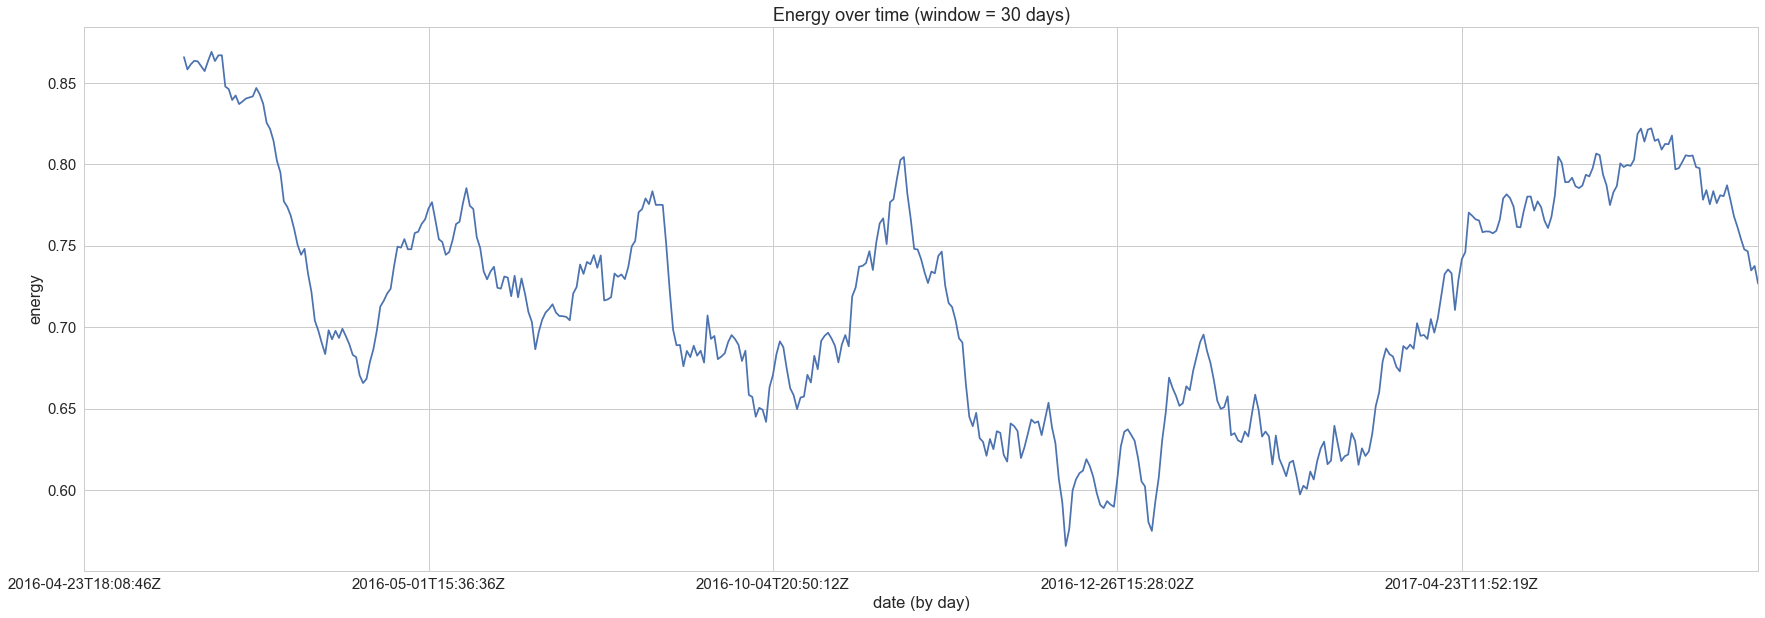

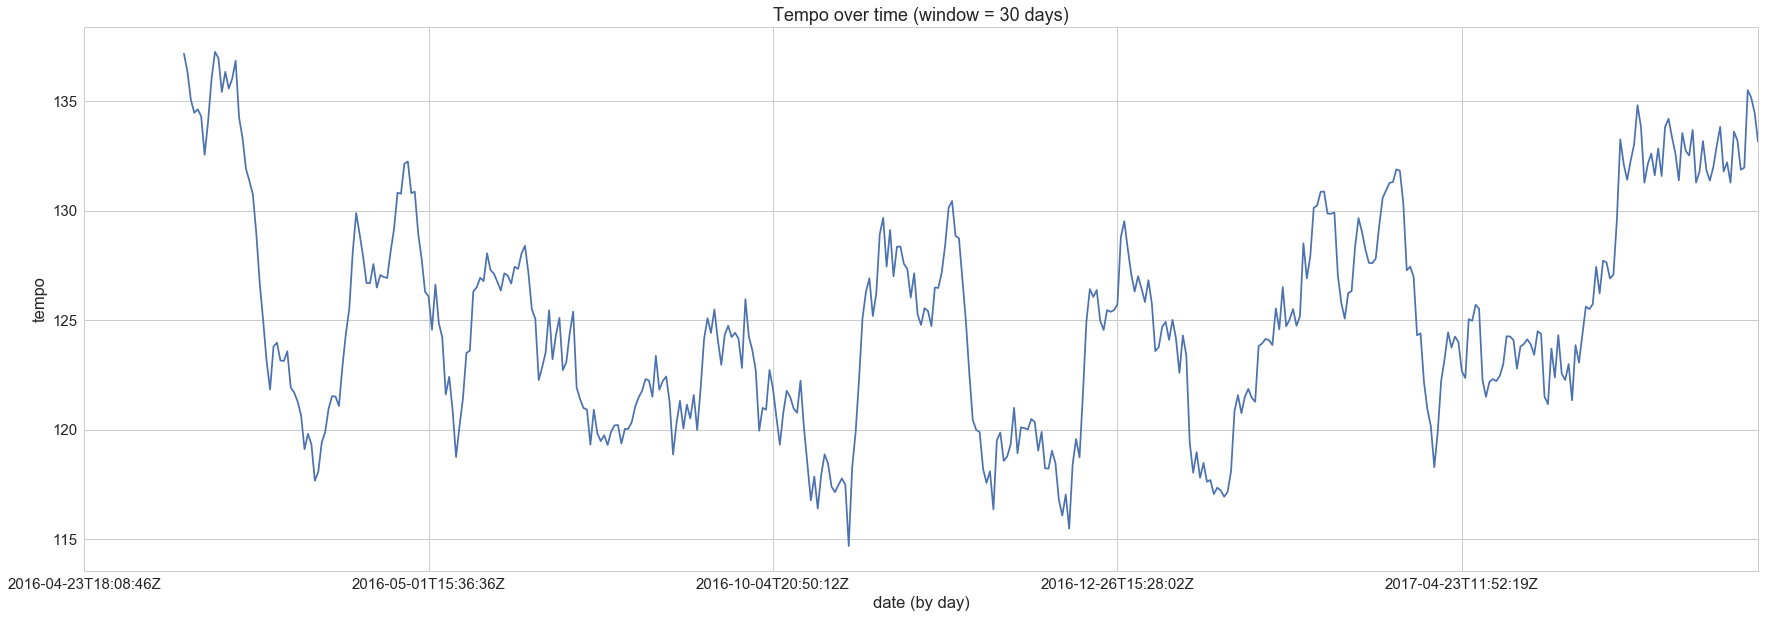

In [17]:
plot_time_series('popularity', 'Popularity over time (window = 30 days)', 30)
plot_time_series('duration_s', 'Duration (s) over time (window = 30 days)', 30)
plot_time_series('danceability', 'Danceability over time (window = 30 days)', 30)
plot_time_series('valence', 'Valence over time (window = 30 days)', 30)
plot_time_series('energy', 'Energy over time (window = 30 days)', 30)
plot_time_series('tempo', 'Tempo over time (window = 30 days)', 30)

In [18]:
def get_genres(artist, spotipy_obj):
    response = spotipy_obj.search(q='artist:' + artist, type='artist')['artists']['items']
    return response[0]['genres'] if response else []

tracks_df['genres'] = tracks_df['artists'].apply(lambda artist: get_genres(artist, spotipy_obj))

In [19]:
genres = []

for gnrs in tracks_df['genres'].tolist():
    genres.extend(gnrs)
    
genres_df = pd.DataFrame(genres, columns=['genre'])

Genres ranking

In [20]:
genres_df['genre'].value_counts()

rock                           182
modern rock                    136
permanent wave                 117
alternative rock               114
indie rock                     104
classic rock                    98
pop                             79
album rock                      75
britpop                         61
hard rock                       60
mellow gold                     59
soft rock                       54
indie pop                       53
garage rock                     48
alternative metal               47
indietronica                    43
pop christmas                   42
dance pop                       37
edm                             35
singer-songwriter               35
art rock                        35
tropical house                  35
pop rock                        34
post-grunge                     33
spanish indie pop               31
dance rock                      31
new wave                        30
psychedelic rock                29
alternative dance   

Some histograms about the info retrieved previously

In [21]:
show(Histogram(tracks_df['valence'], title='Tracks valence (1 = happy, 0 = sad)', bins=50, density=False, plot_width=800))
show(Histogram(tracks_df['danceability'], title='Danceability', bins=50, density=False, plot_width=800))
show(Histogram(tracks_df['loudness'], title='Loudness', bins=50, density=False, plot_width=800))
show(Histogram(tracks_df['tempo'], title='Tempo', bins=50, density=False, plot_width=800))
show(Histogram(tracks_df['energy'], title='Energy', bins=50, density=False, plot_width=800))

In [22]:
pitch_classes = ['C/Do', 'C#/Do sost.', 'D/Re', 'D/Re sost.', 'E/Mi', 'F/Fa', 'F#/Fa sost.', 'G/Sol', 'G#/Sol sost.', 'A/La', 'A#/La sost.', 'B/Si']

tracks_df['key'].replace([str(i) for i in list(range(0, 12))], pitch_classes, inplace=True)

https://en.wikipedia.org/wiki/Pitch_class#Other_ways_to_label_pitch_classes


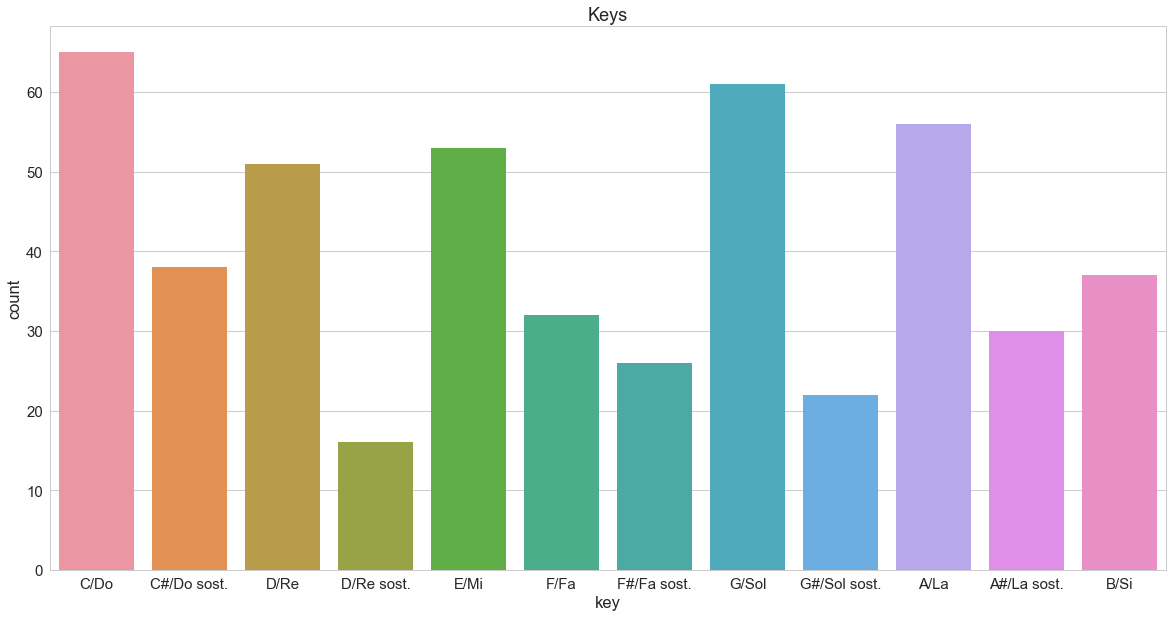

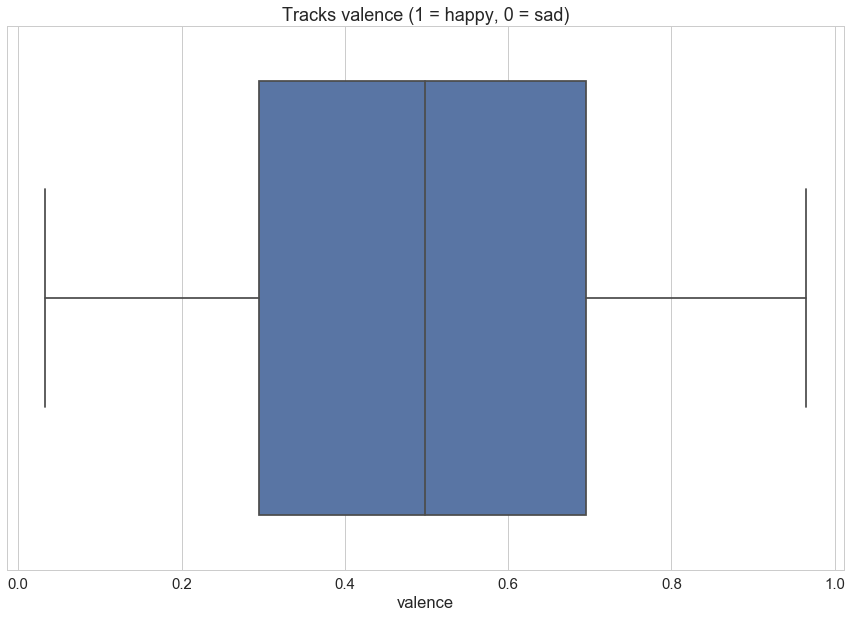

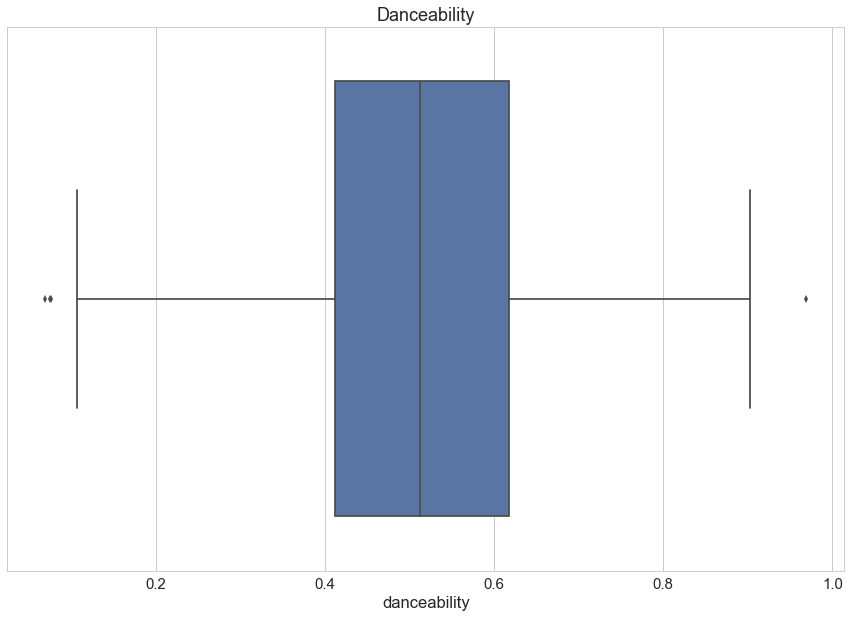

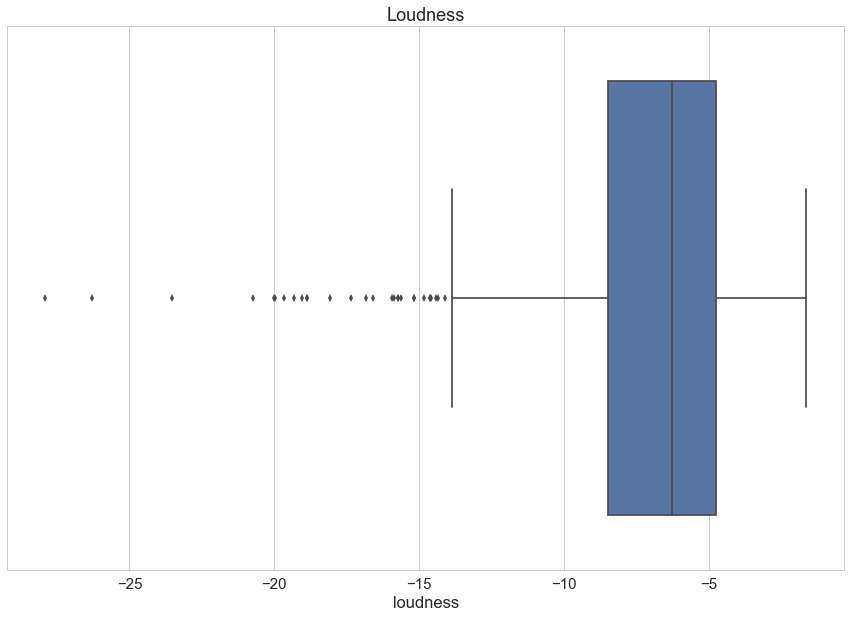

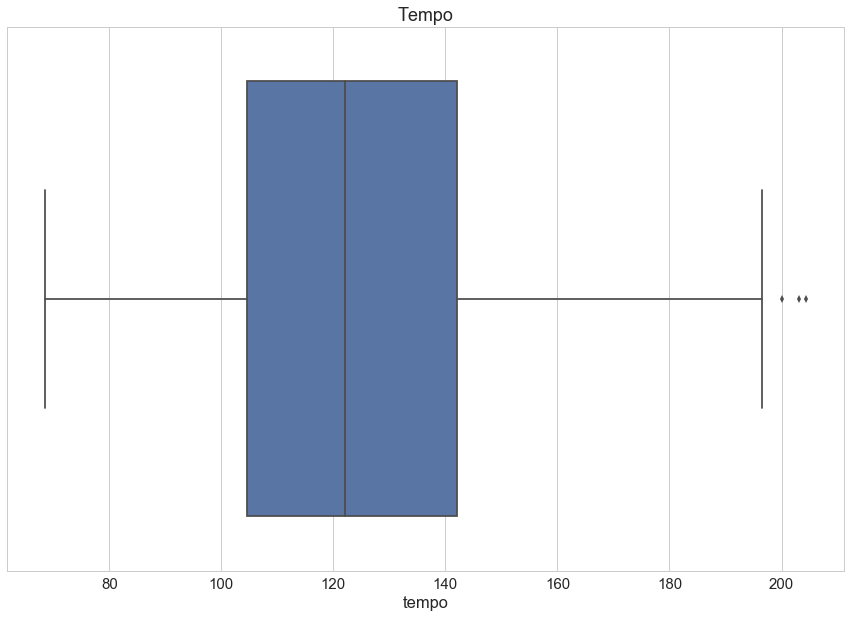

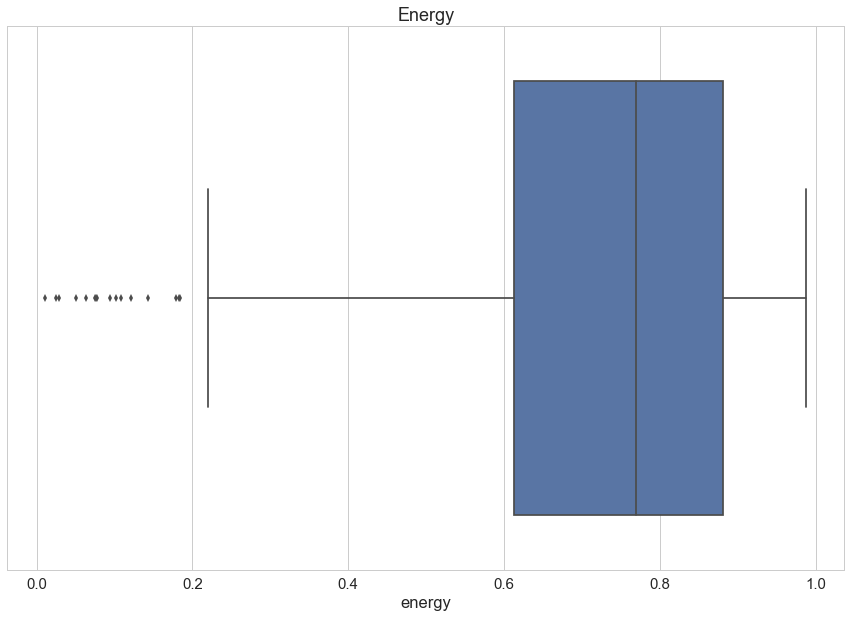

In [23]:
sns.set_context('notebook', font_scale=1.5)
sns.set_style('whitegrid')

print('https://en.wikipedia.org/wiki/Pitch_class#Other_ways_to_label_pitch_classes')
sns.plt.figure(figsize=(20, 10))
(sns.countplot(x=tracks_df['key'], order=pitch_classes)
.set_title('Keys'))
sns.plt.show()

sns.plt.figure(figsize=(15, 10))
sns.boxplot(x=tracks_df['valence']).set_title('Tracks valence (1 = happy, 0 = sad)')
sns.plt.show()

sns.plt.figure(figsize=(15, 10))
sns.boxplot(x=tracks_df['danceability']).set_title('Danceability')
sns.plt.show()

sns.plt.figure(figsize=(15, 10))
sns.boxplot(x=tracks_df['loudness']).set_title('Loudness')
sns.plt.show()

sns.plt.figure(figsize=(15, 10))
sns.boxplot(x=tracks_df['tempo']).set_title('Tempo')
sns.plt.show()

sns.plt.figure(figsize=(15, 10))
sns.boxplot(x=tracks_df['energy']).set_title('Energy')
sns.plt.show()

In [24]:
second_describe = tracks_df[['energy', 'tempo', 'loudness', 'danceability', 'valence']].describe()
second_describe.loc[['mean','std','50%','min','max'],:]

,energy,tempo,loudness,danceability,valence
mean,0.718745,125.520392,-7.155335,0.509394,0.493161
std,0.211414,28.230377,3.719604,0.154199,0.249439
50%,0.769000,122.093000,-6.260000,0.512000,0.498000
min,0.011200,68.560000,-27.908000,0.069500,0.033100
max,0.988000,204.397000,-1.634000,0.969000,0.965000


Songs with most and least energy:

In [25]:
print(tracks_df.iloc[ tracks_df['energy'].idxmax() ][['artists','name', 'energy']])
print()
print(tracks_df.iloc[ tracks_df['energy'].idxmin() ][['artists','name', 'energy']])

artists         Green Day
name       American Idiot
energy              0.988
Name: 58, dtype: object

artists                                 Ludwig van Beethoven
name       Symphony No. 7 in A Major, Op. 92: II. Allegretto
energy                                                0.0112
Name: 293, dtype: object


Songs with most and least valence:

In [26]:
print(tracks_df.iloc[ tracks_df['valence'].idxmax() ][['artists','name', 'valence']])
print()
print(tracks_df.iloc[ tracks_df['valence'].idxmin() ][['artists','name', 'valence']])

artists          Cocoon
name       I Can't Wait
valence           0.965
Name: 172, dtype: object

artists       Vitamin String Quartet
name       Motion Picture Soundtrack
valence                       0.0331
Name: 203, dtype: object


The songs with most and least tempo:

In [27]:
print(tracks_df.iloc[ tracks_df['tempo'].idxmax() ][['artists','name', 'tempo']])
print()
print(tracks_df.iloc[ tracks_df['tempo'].idxmin() ][['artists','name', 'tempo']])

artists         Joan Jett
name       Bad Reputation
tempo             204.397
Name: 195, dtype: object

artists                                 Ludwig van Beethoven
name       Symphony No. 7 in A Major, Op. 92: II. Allegretto
tempo                                                  68.56
Name: 293, dtype: object


The most and the least danceable songs:

In [28]:
print(tracks_df.iloc[ tracks_df['danceability'].idxmax() ][['artists','name', 'danceability']])
print()
print(tracks_df.iloc[ tracks_df['danceability'].idxmin() ][['artists','name', 'danceability']])

artists         Sexual Harrassment
name                I Need A Freak
danceability                 0.969
Name: 214, dtype: object

artists            Vitamin String Quartet
name            Motion Picture Soundtrack
danceability                       0.0695
Name: 203, dtype: object


Here are the loudest and the lest loud songs:

In [29]:
print(tracks_df.iloc[ tracks_df['loudness'].idxmax() ][['artists','name', 'loudness']])
print()
print(tracks_df.iloc[ tracks_df['loudness'].idxmin() ][['artists','name', 'loudness']])

artists             Oasis
name        Morning Glory
loudness           -1.634
Name: 459, dtype: object

artists                                  Ludwig van Beethoven
name        Symphony No. 7 in A Major, Op. 92: II. Allegretto
loudness                                              -27.908
Name: 293, dtype: object


Songs that match or are close to the energy median value:

In [36]:
def sorted_diffed_values(constant, df, field, n_first):
    return df.iloc[(df[field]-constant).abs().argsort()][['artists','name', field]][:n_first]    

In [37]:
sorted_diffed_values(float(format(second_describe['energy']['50%'], '.3f')), tracks_df, 'energy', 5)

,artists,name,energy
188,The Smiths,There Is A Light That Never Goes Out - 2011 Re...,0.769
4,French Montana,Unforgettable,0.769
448,AC/DC,You Shook Me All Night Long,0.768
185,The Growlers,Going Gets Tough,0.768
290,Spiderbait,Calypso,0.771


Songs that match or are close to the tempo median value:

In [32]:
sorted_diffed_values(second_describe['tempo']['50%'], tracks_df, 'tempo', 5)

,artists,name,tempo
74,Bruce Springsteen,Born in the U.S.A.,122.093
370,Love of Lesbian,La noche eterna,122.035
329,Kungs,This Girl - Kungs Vs. Cookin' On 3 Burners,121.969
414,OneRepublic,Counting Stars,121.941
149,Johnny Cash,Cocaine Blues - Live,122.396


Songs that match or are close to the danceability median value:

In [33]:
sorted_diffed_values(float(format(second_describe['danceability']['50%'], '.2f')), tracks_df, 'danceability', 5)

,artists,name,danceability
380,The Vaccines,Panic Attack,0.510
442,Metallica,Whiskey In The Jar,0.511
479,The Vaccines,Give Me a Sign,0.511
33,Linkin Park,Leave Out All The Rest,0.509
166,Miles Kane,Come Closer,0.511


Songs that match or are close to the valence median value:

In [34]:
sorted_diffed_values(float(format(second_describe['valence']['50%'], '.2f')), tracks_df, 'valence', 5)

,artists,name,valence
122,Kygo,It Ain't Me (with Selena Gomez),0.500
281,Don McLean,American Pie,0.498
329,Kungs,This Girl - Kungs Vs. Cookin' On 3 Burners,0.498
67,Joey Ramone,What a Wonderful World,0.503
53,Green Day,Boulevard Of Broken Dreams,0.504


Songs that match or are close to the loudness median value:

In [35]:
sorted_diffed_values(float(format(second_describe['loudness']['50%'], '.2f')), tracks_df, 'loudness', 5)

,artists,name,loudness
124,David Bowie,Suffragette City - Live,-6.260
185,The Growlers,Going Gets Tough,-6.258
31,OMC,How Bizarre,-6.272
485,The Vaccines,Wetsuit,-6.233
217,Weezer,Island In The Sun,-6.224


## Conclusions

According to the median values, I like energetic and loud music (pay attention to the correlation between this two measures at the beginning of this notebook) with tempo above 120 BPM. 

The music I like is not happy either sad, and it's not too danceable. 

The median popularity is 56 out of 100, maybe because I listen to old songs (low popularity) and trending songs (high popularity). 

Apparently, my favourite pitch class is C (Do).

Oh, clearly my favourite music genre is rock and I love Oasis ;)


Next steps? 

* Make groups of songs using a P.A.M. or K-NN algorithms.
* Merge day weather info with my playlist info in order to check if I listen to sad music in rainy/cold days and cheerful music in hot/sunny days.